In [7]:
import pandas as pd
import os
import ast
import matplotlib.pyplot as plt
import seaborn as sns

import IPython.display as ipd
from sklearn.decomposition import PCA 
from sklearn.preprocessing import *
import numpy as np

from sklearn.feature_selection import *
import librosa
import warnings
warnings.filterwarnings("ignore")

In [8]:
# paths for the data

DATA_PATH = "/kaggle/input/fma-small/"
METADATA_PATH = DATA_PATH + "fma_metadata/fma_metadata/"
FMA_SMALL_PATH = DATA_PATH + "fma_small/fma_small/"
FIG_SIZE = (20, 20)

In [9]:
os.listdir(METADATA_PATH)

['echonest.csv',
 'raw_genres.csv',
 'raw_artists.csv',
 'features.csv',
 'genres.csv',
 'README.txt',
 'not_found.pickle',
 'tracks.csv',
 'raw_tracks.csv',
 'raw_albums.csv',
 'raw_echonest.csv',
 'checksums']

In [10]:
def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all'),
                   ('track', 'genres_top')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                'category', categories=SUBSETS, ordered=True)

        COLUMNS = [('track', 'license'), ('artist', 'bio'),
                   ('album', 'type'), ('album', 'information')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks

### **Import Required Modules**

In [12]:
from tensorflow.keras.layers import Dense, Input, Conv2D, Lambda, \
                MaxPooling2D, BatchNormalization, Dropout, AveragePooling2D, Flatten, \
                Bidirectional, GRU, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D, ZeroPadding2D, ELU, ReLU
import tensorflow as tf 
import tensorflow.keras as keras 

### **Tensorflow util functions.**

In [13]:
def convert_to_tensorflow_dataset(X, y, batch_size): 
    """
        this function, will create a tensorflow.data.Dataset object from numpy array.
        Params:
            X(type: np.ndarray): Numpy array, that contains the X data(images in this case).
            y(type: np.array): numpy array, that contains the labels.
            batch_siz(type: Int): BAtches need to be created for each epoch.
    """
    tensorflow_dataset = tf.data.Dataset.from_tensor_slices((X, y))
    tensorflow_dataset = (tensorflow_dataset.shuffle(buffer_size=1024)
                                            .batch(batch_size, drop_remainder=True)
                                            .prefetch(buffer_size=tf.data.AUTOTUNE)
                                        )
    return tensorflow_dataset
    

@tf.function 
def train_step(X, y, model, optimizer, loss_function, metric_function):
    with tf.GradientTape() as tape: 
        probs = model(X, training=True)
        y = tf.cast(y, dtype=tf.float32)
     #   print(y)
        loss_val = loss_function(probs, y)

    params = model.trainable_weights
    grads = tape.gradient(loss_val, params)
    optimizer.apply_gradients(zip(grads, params))
    metric_function.update_state(y, probs)
    
    return loss_val 


@tf.function 
def val_step(X, y, model, loss_function, metric_function): 
    preds_prob = model(X, training=False)
    y = tf.cast(y, dtype=tf.float32)
    loss_val = loss_function(preds_prob, y)
    metric_function.update_state(y, preds_prob)
    
    return loss_val

### **Custom CNN Keras Model**

In [ ]:
class CNNModel(keras.models.Model): 
    def __init__(self, input_dims, out_dims):
        super(CNNModel, self).__init__()
        self.input_dims = input_dims 
        self.out_dims = out_dims 
        
        self.conv1 = Conv2D(16, kernel_size = (3,1), strides=1,
                                padding= 'valid', activation='relu', name='conv_1', input_shape=self.input_dims)
        self.conv2  = Conv2D(32, kernel_size = (3,1), strides=1,
                                              padding= 'valid', activation='relu')
        self.conv3 =  Conv2D(64, kernel_size = (3,1), strides=1,
                                              padding= 'valid', activation='relu')
        
        self.conv4 = Conv2D(64, kernel_size = (3,1), strides=1,
                                              padding= 'valid', activation='relu')
    
        self.conv5 = Conv2D(64, kernel_size = (3,1), strides=1,
                                              padding= 'valid', activation='relu')

        
        self.bn = BatchNormalization()
        self.pool1 = MaxPooling2D((2, 2))
        self.pool2 = MaxPooling2D((2, 2))
        self.pool3 = MaxPooling2D((2, 2))
        self.pool4 = MaxPooling2D((4, 4))
        self.pool5 = MaxPooling2D((4, 4))
        self.dropout = Dropout(0.5)
        self.lstm = Bidirectional(GRU(64))
        self.pool_lstm1 = MaxPooling2D((4, 2))
        
        self.flatten = keras.layers.Flatten()
        self.dense1 = Dense(128, activation='relu', kernel_initializer="he_uniform")
        self.out = Dense(self.out_dims, activation="softmax")
        
        
    def call(self, tensor):
        x = self.conv1(tensor)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.conv5(x)
        x = self.pool5(x)
        x = self.flatten(x)
        
        pool_lstm1 = self.pool_lstm1(tensor)
        squeezed = Lambda(lambda x: tf.squeeze(x, axis= -1))(pool_lstm1)
        
        lstm = self.lstm(squeezed)
        concat = keras.layers.concatenate([x, lstm], axis=-1)
        
        out = self.out(concat)
        
        return out

### **Plotting Functions**

In [14]:
import matplotlib.pyplot as plt 

def plot_acc(history): 
    """
        this function, used to plot the Train data Accuracy and Val data Accuracy.
        Params:
            history(type: tf.History): history object, returned by the keras model .fit() method.
        Return(type: None)
    """
    with plt.xkcd():
        plt.plot(history.history["acc"], label="train_acc")
        plt.plot(history.history["val_acc"], label="val_acc")
        plt.title("Training and val Accuracy")
        plt.xlabel("Epoch #")
        plt.ylabel("Accuracy")
        plt.legend(loc="lower left")
        
        plt.show()
        
def plot_loss(history):  
    """
        this function, used to plot the Train data Loss and Val data Loss.
        Params:
            history(type: tf.History): history object, returned by the keras model .fit() method.
        Return(type: None)
    """
    with plt.xkcd():
        plt.plot(history.history["loss"], label="train_loss")
        plt.plot(history.history["val_loss"], label="val_loss")

        plt.title("Training Loss and val loss")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss")
        plt.legend(loc="lower left")
        
        plt.show()

### **Custom tensorflow training function**

In [15]:
import tqdm 
from collections import *

def train_model(model, training_data, validation_data, optimizer, loss_function, 
                          metric_function, val_metric_function, batch_size, test_step, epochs): 
    
    train_epochs_loss, val_epochs_loss = [], []
    train_epochs_acc, val_epochs_acc = [], []
    history = defaultdict(list)
    for epoch in range(epochs): 
        train_batch_loss = []
        val_batch_loss = []
        train_batch_acc = []
        val_batch_acc = []
        
        for batch_indx, (training_X_batch, training_y_batch) in \
                        tqdm.tqdm(enumerate(training_data), total=len(training_data)): 
            
            train_loss = model.train_on_batch(training_X_batch, training_y_batch)
            train_preds = model.predict_on_batch(training_X_batch)
                        
            train_batch_loss.append(train_loss)
            train_batch_acc.append(metric_function(training_y_batch, train_preds))
    
        for batch_indx, (val_X_batch, val_y_batch) in enumerate(validation_data):

            val_loss = model.test_on_batch(val_X_batch, val_y_batch)
            val_batch_loss.append(val_loss)
    
            val_preds = model.predict_on_batch(training_X_batch)
            val_batch_acc.append(val_metric_function(val_y_batch, val_preds))

        epoch_train_acc = np.mean(train_batch_acc)
        epoch_val_acc = np.mean(val_batch_acc)
        epoch_val_loss = np.mean(val_batch_loss)
        epoch_train_loss = np.mean(train_batch_loss)
        
        history["train_epochs_loss"].append(epoch_train_loss)
        history["val_epochs_loss"].append(epoch_val_loss)
        history["train_epochs_acc"].append(epoch_train_acc)
        history["val_epochs_acc"].append(epoch_val_acc)
        
        print(f"Epoch {epoch} loss: {epoch_train_loss} val_loss: {epoch_val_loss} accuracy: {epoch_train_acc} val_accuracy: {epoch_val_acc}")
        
    return model, history

### **Custom Metric Class**


In [78]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

class Metrics: 
    def __init__(self, y_preds, y_trues, class_names, avg, heatmap=True):
        """
            this class has a multiple methods that has multiple evulation metrics for the evaulating the prediction data.
            Attrs:
                y_preds(type: np.array): prediction from the model.
                y_trues(type; np.array): Actual value(true value) of the dataset.
                class_names(type: List): list of classes.
                avg(type: str): Type of method for averaging the multiclass values.
        """
        self.y_preds = y_preds 
        self.y_trues = y_trues 
        self.class_names = class_names
        self.avg = avg 
        self.heatmap = heatmap

    @property
    def get_classification_report(self):
        """
            returns the classiction report.
        """
        report = classification_report(self.y_trues, self.y_preds, target_names=self.class_names)
        return report

    @property
    def f1score(self): 
        """
            returns the f1 score.
        """
        score = f1_score(self.y_trues. self.y_preds, average=self.avg)
        return score 
        
    @property
    def accuracy(self):
        """
            returns the accuracy
        """
        acc = accuracy_score(self.y_trues, self.y_preds)
        return acc 

    @property
    def heatmap_cmat(self): 
        """
            returns the heatmap for the confusion matrix.
        """
        mat = confusion_matrix(self.y_trues, self.y_preds)
        sns.heatmap(
                    mat.T, 
                    square=True, 
                    annot=True, 
                    fmt='d', 
                    cbar=False,
                    xticklabels=self.class_names,
                    yticklabels=self.class_names
                )
        plt.xlabel('true label')
        plt.ylabel('predicted label');

### **Data Loading util functions**

In [82]:
def load_tf_dataset(train_fpath, val_fpath, input_dims, batch_size): 
    """
        this function, will load the data from npz files, and uses the convert_to_tensorflow_dataset function, 
        to convert the numpy array as a tf.data.Dataset object, which uses GPU better.
        Params:
            train_path(type: str): Training data path(path of train npz file).
            val_fpath(type: str): Validation data path(path of train npz file).
            input_dims(type: tuple): Input Dimesion for the each sample(RNN model, needs a 2D, CNN model, needs 3D)
            batch_size: Batch Size, used by the convert_to_tensorflow_dataset function.
        Return(type: tf.data.Dataset, tf.data.Dataset)
            returns the converted train and val dataset(tensorflow dataset).
    """
    loaded = np.load(train_fpath)
    train_X, train_y = loaded['X'], loaded["y"]

    loaded = np.load(test_fpath)

    loaded = np.load(val_fpath)
    val_X, val_y = loaded['X'], loaded["y"]

    train_X = np.reshape(train_X, (train_X.shape[0], *input_dims))
    val_X = np.reshape(val_X, (val_X.shape[0], *input_dims))

    train_ds = convert_to_tensorflow_dataset(train_X, pd.get_dummies(train_y), batch_size)
    val_ds = convert_to_tensorflow_dataset(val_X, pd.get_dummies(val_y), batch_size)
    
    del train_x, train_y, val_X, val_y
    return train_ds, val_ds
    
    
def get_test_data(test_fpath, input_dims): 
    """
        this function, will load the data from npz files, but won't convert to tf.data.Dataset.
        Params:
            test_fpath(type: str): Testing data path(path of train npz file).
            input_dims(type: tuple): Input Dimesion for the each sample(RNN model, needs a 2D, CNN model, needs 3D)
        Return(type: (np.ndarray, np.array))
            returns the np array of testing X and np array of testing y.
    """
    loaded = np.load(test_fpath)
    test_X, test_y = loaded['X'], loaded["y"]
    test_X = np.reshape(test_X, (test_X.shape[0], *input_dims))
    
    return test_X, test_y

In [56]:
train_ds_rnn, val_ds_rnn = load_tf_dataset('chroma-train.npz', "chroma-val.npz", (13, 1280), 64)
train_ds_cnn, val_ds_cnn = load_tf_dataset('chroma-train.npz', "chroma-val.npz", (13, 1280, 1), 64)

In [83]:
test_X_rnn, test_y_rnn = get_test_data("chroma-test.npz", (13, 1280))
test_X_cnn, test_y_cnn = get_test_data("chroma-test.npz", (13, 1280, 1))

In [22]:
CHROMA_CNN_INPUT_SHAPE = (13, 1280)
print(f'Input shape; {CHROMA_CNN_INPUT_SHAPE}')

CHROMA_RNN_INPUT_SHAPE = (13, 1280)
print(f'Input shape; {CHROMA_RNN_INPUT_SHAPE}')

Input shape; (13, 1280)


### **CRNN (Convoluational Recurrent Neural Network) with GRU**

In [113]:
def build_crnn_gru_model(input_dims, out_dims):
  """
    this function, will create a CRNN model, which will get a image spatial information, and pass it
    to the GRU layer.
    Params:
      input_dims(type: tuple): Input dimesion for the image.
      out_dims(type: Int): output dimesion.
    Return(type: keras.Model):
      returns crnn keras model.
  """
  print('Building model...')
    
  channel_axis = 3
  freq_axis = 1
  padding = 37

  model = Sequential()
  model.add(ZeroPadding2D(padding=(0, padding), data_format='channels_last', input_shape=input_dims))
  model.add(BatchNormalization(axis=freq_axis, name='bn_0_freq'))

  model.add(Conv2D(64, (3, 3), padding='same', name='conv1'))
  model.add(BatchNormalization(axis=channel_axis, name='bn1'))
  model.add(ReLU())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1'))
  model.add(Dropout(0.1, name='dropout1'))

  model.add(Conv2D(128, (3, 3), padding='same', name='conv2'))
  model.add(BatchNormalization(axis=channel_axis, name='bn2'))
  model.add(ReLU())
  model.add(MaxPooling2D(pool_size=(3, 3), strides=(3, 3), name='pool2'))
  model.add(Dropout(0.1, name='dropout2'))

  model.add(Reshape(target_shape=(450, 128)))
    
  model.add(GRU(32, return_sequences=True, name='gru1'))
  model.add(GRU(64, return_sequences=False, name='gru2'))

  model.add(Dropout(0.1, name='dropout_final'))
  model.add(Dense(128))

  model.add(Dense(out_dims, activation='softmax', name='output'))

  return model

In [114]:
crnn_gru_model = build_crnn_gru_model((13, 1280, 1), len(label_map))
crnn_gru_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics="acc")
history = crnn_gru_model.fit(train_ds_cnn, batch_size=64, verbose=1, epochs=30, validation_data=val_ds_cnn)

Building model...
Epoch 1/30


2023-05-03 14:19:17.574098: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_10/dropout1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


78/78 [==============================] - 15s 137ms/step - loss: 1.9084 - acc: 0.2494 - val_loss: 2.1947 - val_acc: 0.1198
Epoch 2/30
78/78 [==============================] - 9s 120ms/step - loss: 1.7797 - acc: 0.3269 - val_loss: 2.7474 - val_acc: 0.1641
Epoch 3/30
78/78 [==============================] - 9s 119ms/step - loss: 1.7159 - acc: 0.3628 - val_loss: 3.0685 - val_acc: 0.1693
Epoch 4/30
78/78 [==============================] - 9s 119ms/step - loss: 1.6991 - acc: 0.3620 - val_loss: 2.9822 - val_acc: 0.2057
Epoch 5/30
78/78 [==============================] - 9s 120ms/step - loss: 1.6591 - acc: 0.3986 - val_loss: 2.6729 - val_acc: 0.2747
Epoch 6/30
78/78 [==============================] - 9s 120ms/step - loss: 1.6195 - acc: 0.4119 - val_loss: 2.2597 - val_acc: 0.2773
Epoch 7/30
78/78 [==============================] - 9s 120ms/step - loss: 1.6174 - acc: 0.4077 - val_loss: 1.8743 - val_acc: 0.3216
Epoch 8/30
78/78 [==============================] - 9s 120ms/step - loss: 1.5708 - acc

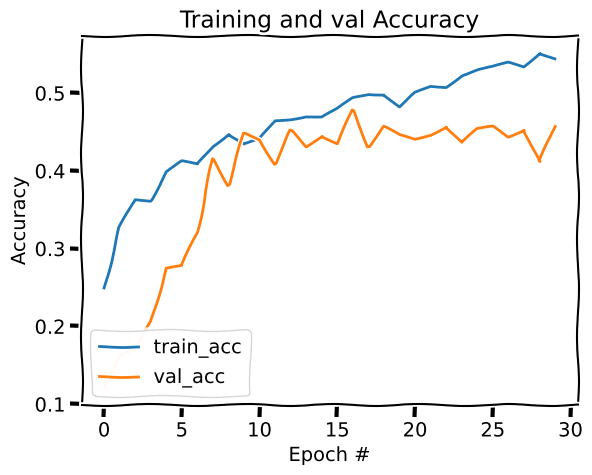

In [115]:
plot_acc(history)

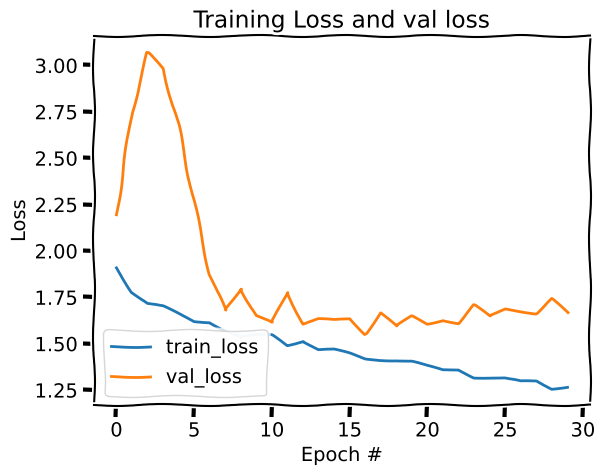

In [116]:
plot_loss(history)

In [117]:
crnn_gru_model.save("chroma_cnn_gru.h5")

### **Model Evaluation**

In [118]:
pred_y = np.argmax(crnn_gru_model.predict(test_X), axis=1)

25/25 [==============================] - 1s 19ms/step


In [119]:
custom_metric_gen = Metrics(pred_y, test_y, list(label_map.keys()), "weighted", True)

In [120]:
custom_metric_gen.accuracy

0.38875

In [121]:
print(custom_metric_gen.get_classification_report)

               precision    recall  f1-score   support

   Electronic       0.39      0.51      0.44       100
 Experimental       0.20      0.18      0.19       100
         Folk       0.31      0.41      0.35       100
      Hip-Hop       0.62      0.61      0.62       100
 Instrumental       0.33      0.64      0.43       100
International       0.65      0.20      0.31       100
          Pop       0.27      0.08      0.12       100
         Rock       0.54      0.48      0.51       100

     accuracy                           0.39       800
    macro avg       0.41      0.39      0.37       800
 weighted avg       0.41      0.39      0.37       800



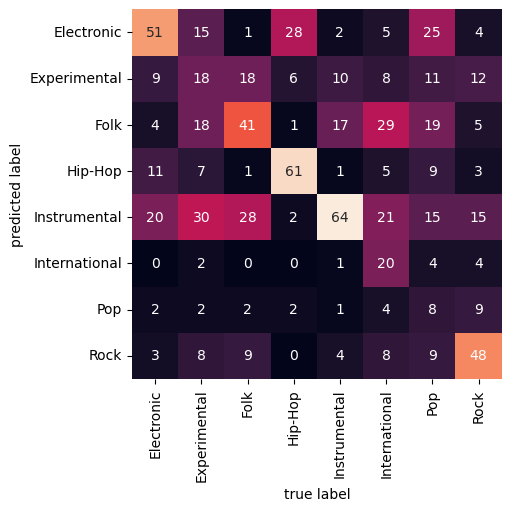

In [122]:
custom_metric_gen.heatmap_cmat

### **CRNN (Convoluational Recurrent Neural Network) with LSTM**

In [102]:
def build_crnn_lstm_model(input_dims, out_dims):
    """
        this function, will create a CRNN model, which will get a image spatial information, and pass it
        to the LSTM layer.
        Params:
        input_dims(type: tuple): Input dimesion for the image.
        out_dims(type: Int): output dimesion.
        Return(type: keras.Model):
        returns crnn keras model.
    """
    print('Building model...')
    
    channel_axis = 3
    freq_axis = 1
    padding = 37

    model = Sequential()
    model.add(ZeroPadding2D(padding=(0, padding), data_format='channels_last', input_shape=input_dims))
    model.add(BatchNormalization(axis=freq_axis, name='bn_0_freq'))

    model.add(Conv2D(64, (3, 3), padding='same', name='conv1'))
    model.add(BatchNormalization(axis=channel_axis, name='bn1'))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1'))
    model.add(Dropout(0.1, name='dropout1'))

    model.add(Conv2D(128, (3, 3), padding='same', name='conv2'))
    model.add(BatchNormalization(axis=channel_axis, name='bn2'))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(3, 3), name='pool2'))
    model.add(Dropout(0.1, name='dropout2'))

    model.add(Reshape(target_shape=(450, 128)))
    
    model.add(LSTM(32, return_sequences=True, name='gru1'))
    model.add(LSTM(64, return_sequences=False, name='gru2'))

    model.add(Dropout(0.1, name='dropout_final'))
    model.add(Dense(128))

    model.add(Dense(out_dims, activation='softmax', name='output'))

    return model

In [104]:
crnn_lstm_model = build_crnn_lstm_model((13, 1280, 1), len(label_map))
crnn_lstm_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics="acc")
history = crnn_lstm_model.fit(train_ds_cnn, batch_size=64, verbose=1, epochs=40, validation_data=val_ds_cnn)

Building model...
Epoch 1/40


2023-05-03 14:11:42.348735: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


78/78 [==============================] - 15s 137ms/step - loss: 1.9387 - acc: 0.2304 - val_loss: 2.2360 - val_acc: 0.1484
Epoch 2/40
78/78 [==============================] - 10s 130ms/step - loss: 1.8790 - acc: 0.2774 - val_loss: 2.3321 - val_acc: 0.1211
Epoch 3/40
78/78 [==============================] - 10s 127ms/step - loss: 1.8446 - acc: 0.2969 - val_loss: 2.1749 - val_acc: 0.1419
Epoch 4/40
78/78 [==============================] - 10s 127ms/step - loss: 1.8038 - acc: 0.3257 - val_loss: 2.2935 - val_acc: 0.2174
Epoch 5/40
78/78 [==============================] - 10s 127ms/step - loss: 1.7978 - acc: 0.3253 - val_loss: 2.1548 - val_acc: 0.2656
Epoch 6/40
78/78 [==============================] - 10s 127ms/step - loss: 1.7672 - acc: 0.3399 - val_loss: 2.0147 - val_acc: 0.2448
Epoch 7/40
78/78 [==============================] - 10s 127ms/step - loss: 1.7326 - acc: 0.3502 - val_loss: 1.8029 - val_acc: 0.3255
Epoch 8/40
78/78 [==============================] - 10s 127ms/step - loss: 1.716

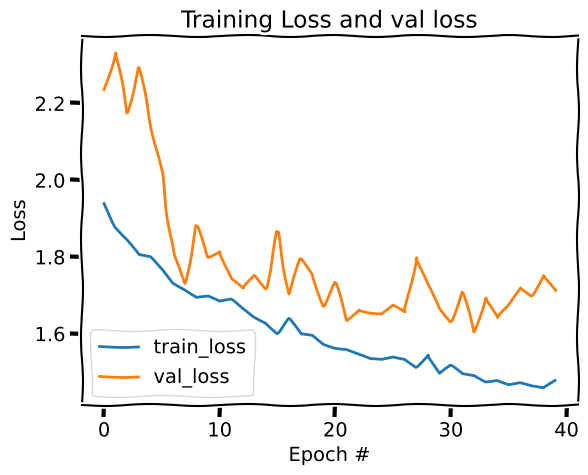

In [105]:
plot_loss(history)

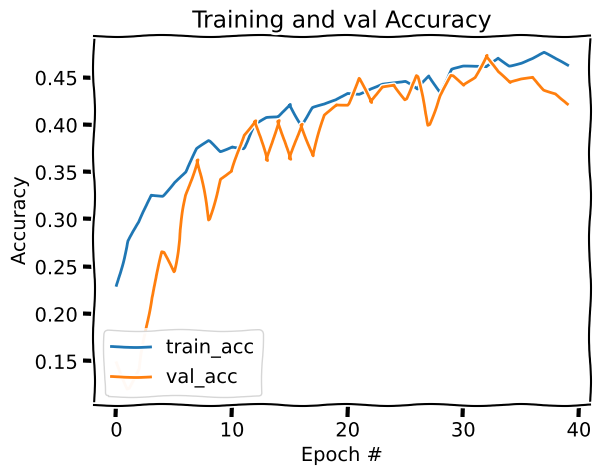

In [106]:
plot_acc(history)

In [107]:
crnn_lstm_model.save("chroma_crnn_lstm.h5")

### **Model Evaluation**

In [108]:
pred_y = np.argmax(crnn_lstm_model.predict(test_X), axis=1)

25/25 [==============================] - 1s 22ms/step


In [109]:
custom_metric_gen = Metrics(pred_y, test_y, list(label_map.keys()), "weighted", True)

In [110]:
custom_metric_gen.accuracy

0.38625

In [111]:
print(custom_metric_gen.get_classification_report)

               precision    recall  f1-score   support

   Electronic       0.41      0.39      0.40       100
 Experimental       0.33      0.13      0.19       100
         Folk       0.29      0.52      0.37       100
      Hip-Hop       0.66      0.55      0.60       100
 Instrumental       0.40      0.63      0.49       100
International       0.30      0.11      0.16       100
          Pop       0.17      0.02      0.04       100
         Rock       0.38      0.74      0.50       100

     accuracy                           0.39       800
    macro avg       0.37      0.39      0.34       800
 weighted avg       0.37      0.39      0.34       800



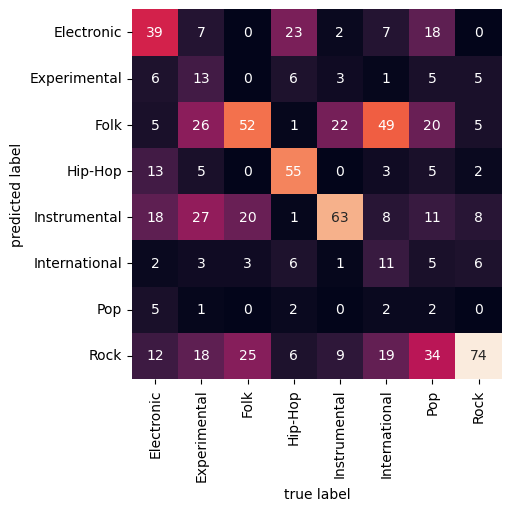

In [112]:
custom_metric_gen.heatmap_cmat

### **CNN (Convoluational Neural Network)**

In [84]:
def build_cnn_model(input_dims, out_dims):
  """
        this function, will create a CNN model, which will get a image spatial information, and pass it
        to the Fully Connected layer.
        Params:
        input_dims(type: tuple): Input dimesion for the image.
        out_dims(type: Int): output dimesion.
        Return(type: keras.Model):
        returns crnn keras model.
    """
    print('Building model...')
    
    channel_axis = 3
    freq_axis = 1
    padding = 37

    model = Sequential()
    model.add(ZeroPadding2D(padding=(0, padding), data_format='channels_last', input_shape=input_dims))
    model.add(BatchNormalization(axis=freq_axis, name='bn_0_freq'))

    model.add(Conv2D(64, (3, 3), padding='same', name='conv1'))
    model.add(BatchNormalization(axis=channel_axis, name='bn1'))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1'))
    model.add(Dropout(0.1, name='dropout1'))

    model.add(Conv2D(128, (3, 3), padding='same', name='conv2'))
    model.add(BatchNormalization(axis=channel_axis, name='bn2'))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(3, 3), name='pool2'))
    model.add(Dropout(0.1, name='dropout2'))

    model.add(Flatten())
    model.add(Dense(128))

    model.add(Dense(out_dims, activation='softmax', name='output'))

    return model

In [86]:
cnn_model = build_cnn_model((13, 1280, 1), len(label_map))
cnn_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics="acc")
history = cnn_model.fit(train_ds_cnn, verbose=1, epochs=50, validation_data=val_ds_cnn)

Building model...
Epoch 1/50


2023-05-03 13:59:27.315596: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


78/78 [==============================] - 9s 78ms/step - loss: 113.9906 - acc: 0.1747 - val_loss: 16.7455 - val_acc: 0.1237
Epoch 2/50
78/78 [==============================] - 6s 76ms/step - loss: 21.3437 - acc: 0.2165 - val_loss: 20.4435 - val_acc: 0.1484
Epoch 3/50
78/78 [==============================] - 6s 75ms/step - loss: 20.0320 - acc: 0.2422 - val_loss: 15.2303 - val_acc: 0.1367
Epoch 4/50
78/78 [==============================] - 6s 76ms/step - loss: 17.0184 - acc: 0.2570 - val_loss: 20.0064 - val_acc: 0.1341
Epoch 5/50
78/78 [==============================] - 6s 76ms/step - loss: 15.7710 - acc: 0.2724 - val_loss: 20.2525 - val_acc: 0.1836
Epoch 6/50
78/78 [==============================] - 6s 76ms/step - loss: 9.6926 - acc: 0.3385 - val_loss: 15.1567 - val_acc: 0.2096
Epoch 7/50
78/78 [==============================] - 6s 77ms/step - loss: 8.0335 - acc: 0.3383 - val_loss: 11.2642 - val_acc: 0.1901
Epoch 8/50
78/78 [==============================] - 6s 76ms/step - loss: 7.0963 -

In [101]:
cnn_model.save("chroma_cnn.h5")

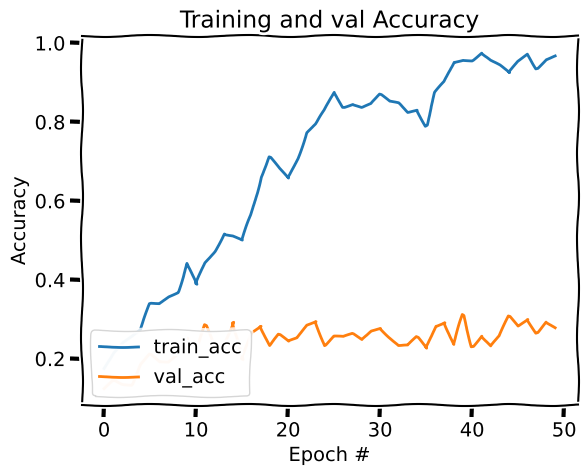

In [87]:
plot_acc(history)

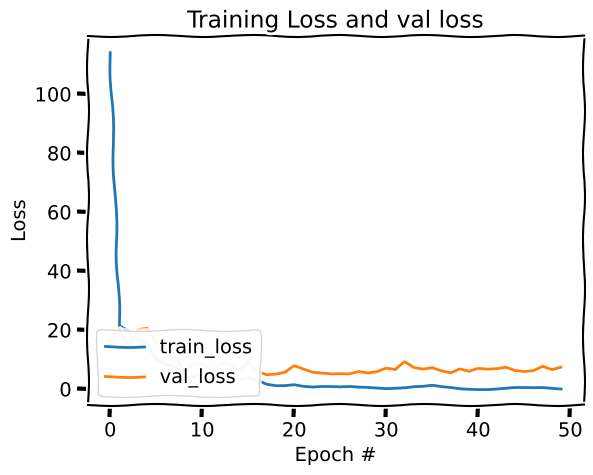

In [88]:
plot_loss(history)

### **Model Evaluation**

In [95]:
pred_y = np.argmax(cnn_model.predict(test_X), axis=1)

25/25 [==============================] - 0s 10ms/step


In [96]:
custom_metric_gen = Metrics(pred_y, test_y, list(label_map.keys()), "weighted", True)

In [97]:
custom_metric_gen.accuracy

0.25875

In [99]:
print(custom_metric_gen.get_classification_report)

               precision    recall  f1-score   support

   Electronic       0.40      0.17      0.24       100
 Experimental       0.10      0.05      0.07       100
         Folk       0.29      0.12      0.17       100
      Hip-Hop       0.39      0.46      0.42       100
 Instrumental       0.24      0.53      0.33       100
International       0.10      0.03      0.05       100
          Pop       0.20      0.13      0.16       100
         Rock       0.25      0.58      0.35       100

     accuracy                           0.26       800
    macro avg       0.25      0.26      0.22       800
 weighted avg       0.25      0.26      0.22       800



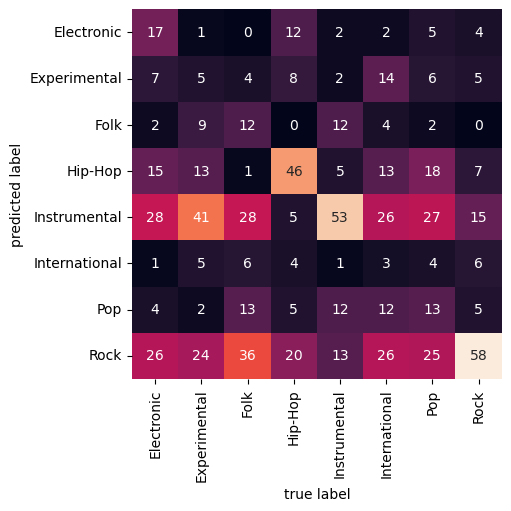

In [100]:
custom_metric_gen.heatmap_cmat

### **RNN (Recurrent Neural Network) Model**

In [72]:
def build_rnn(input_shape, out_shape):
    model = tf.keras.Sequential()

  #  model.add(tf.keras.layers.Input(shape=input_shape))
    model.add(Bidirectional(LSTM(50, return_sequences=True, activation='relu')))
    model.add(Bidirectional(LSTM(150, return_sequences=True, activation='relu')))
    model.add(Bidirectional(LSTM(200, return_sequences=True, activation='relu')))
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.GlobalAvgPool1D())
    model.add(tf.keras.layers.Dense(64, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(out_shape))
    model.add(tf.keras.layers.Activation('softmax'))
    
    return model

In [73]:
rnn_model = build_rnn(CHROMA_INPUT_SHAPE, len(label_map))
rnn_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics="acc")
history = rnn_model.fit(train_ds_rnn, batch_size=64, verbose=1, epochs=40, validation_data=val_ds_rnn)  

Epoch 1/40
78/78 [==============================] - 17s 83ms/step - loss: 2.0602 - acc: 0.1424 - val_loss: 2.0395 - val_acc: 0.1237
Epoch 2/40
78/78 [==============================] - 6s 74ms/step - loss: 2.0381 - acc: 0.1697 - val_loss: 1.9473 - val_acc: 0.2331
Epoch 3/40
78/78 [==============================] - 6s 73ms/step - loss: 1.9960 - acc: 0.2043 - val_loss: 1.9052 - val_acc: 0.2357
Epoch 4/40
78/78 [==============================] - 6s 72ms/step - loss: 1.9698 - acc: 0.2097 - val_loss: 1.9061 - val_acc: 0.2383
Epoch 5/40
78/78 [==============================] - 6s 72ms/step - loss: 1.9577 - acc: 0.2163 - val_loss: 1.8792 - val_acc: 0.2461
Epoch 6/40
78/78 [==============================] - 6s 71ms/step - loss: 1.9455 - acc: 0.2296 - val_loss: 1.8753 - val_acc: 0.2630
Epoch 7/40
78/78 [==============================] - 6s 72ms/step - loss: 1.9369 - acc: 0.2137 - val_loss: 1.8717 - val_acc: 0.2539
Epoch 8/40
78/78 [==============================] - 6s 72ms/step - loss: 1.9282 - 

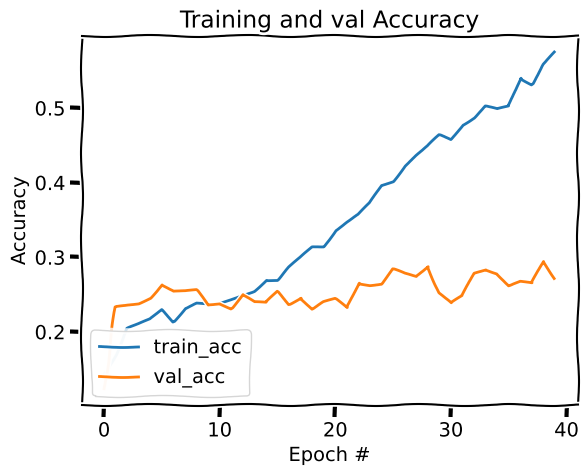

In [74]:
plot_acc(history)

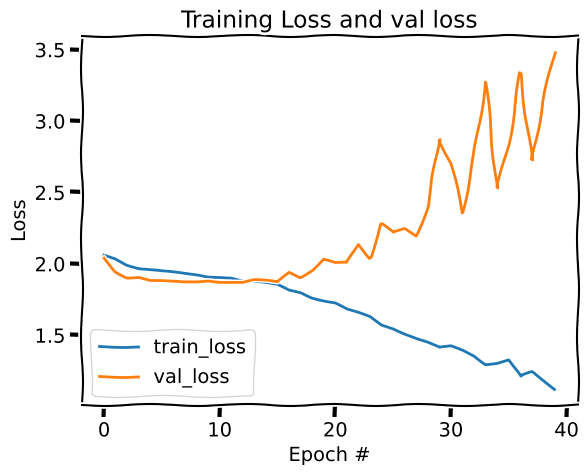

In [75]:
plot_loss(history)

### **Model Evaluation**

In [ ]:
pred_y = np.argmax(bilstm_model.predict(test_X), axis=1)

In [ ]:
custom_metric_gen = Metrics(pred_y, test_y, list(label_map.keys()), "weighted", True)

In [ ]:
custom_metric_gen.accuracy

In [ ]:
custom_metric_gen.heatmap_cmat

### **CRNN with Bi-Directional LSTM**

In [33]:
def build_bilstmcnn_model(input_dims, out_dims):
    print('Building model...')
    
    channel_axis = 3
    freq_axis = 1
    padding = 37

    model = Sequential()
    model.add(ZeroPadding2D(padding=(0, padding), data_format='channels_last', input_shape=input_dims))
    model.add(BatchNormalization(axis=freq_axis, name='bn_0_freq'))

    model.add(Conv2D(64, (3, 3), padding='same', name='conv1'))
    model.add(BatchNormalization(axis=channel_axis, name='bn1'))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1'))
    model.add(Dropout(0.1, name='dropout1'))

    model.add(Conv2D(128, (3, 3), padding='same', name='conv2'))
    model.add(BatchNormalization(axis=channel_axis, name='bn2'))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(3, 3), name='pool2'))
    model.add(Dropout(0.1, name='dropout2'))

    model.add(Reshape(target_shape=(450, 128)))

    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(128, return_sequences=False)))

    model.add(Dropout(0.2, name='dropout_final'))

    model.add(Dense(out_dims, activation='softmax', name='output'))

    return model

In [34]:
bilstm_model = build_bilstmcnn_model((13, 1280, 1), len(label_map))
bilstm_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics="acc")
history = bilstm_model.fit(train_ds_cnn, batch_size=64, verbose=1, epochs=40, validation_data=val_ds_cnn)  

Building model...
Epoch 1/40


2023-05-03 13:04:32.337540: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


78/78 [==============================] - 25s 232ms/step - loss: 1.9032 - acc: 0.2484 - val_loss: 2.1700 - val_acc: 0.1966
Epoch 2/40
78/78 [==============================] - 17s 215ms/step - loss: 1.8167 - acc: 0.3047 - val_loss: 2.6815 - val_acc: 0.1276
Epoch 3/40
78/78 [==============================] - 17s 215ms/step - loss: 1.7993 - acc: 0.3193 - val_loss: 2.3411 - val_acc: 0.1536
Epoch 4/40
78/78 [==============================] - 17s 215ms/step - loss: 1.7629 - acc: 0.3413 - val_loss: 2.3907 - val_acc: 0.1745
Epoch 5/40
78/78 [==============================] - 17s 215ms/step - loss: 1.7145 - acc: 0.3602 - val_loss: 2.2657 - val_acc: 0.2526
Epoch 6/40
78/78 [==============================] - 17s 215ms/step - loss: 1.7285 - acc: 0.3638 - val_loss: 2.3774 - val_acc: 0.2018
Epoch 7/40
78/78 [==============================] - 17s 215ms/step - loss: 1.7239 - acc: 0.3594 - val_loss: 1.8350 - val_acc: 0.3164
Epoch 8/40
78/78 [==============================] - 17s 215ms/step - loss: 1.693

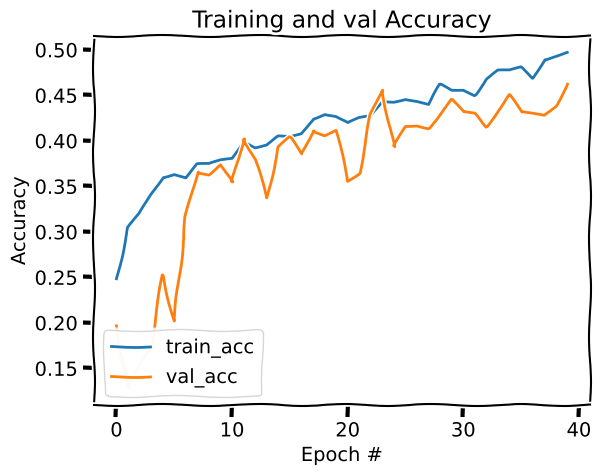

In [37]:
plot_acc(history)

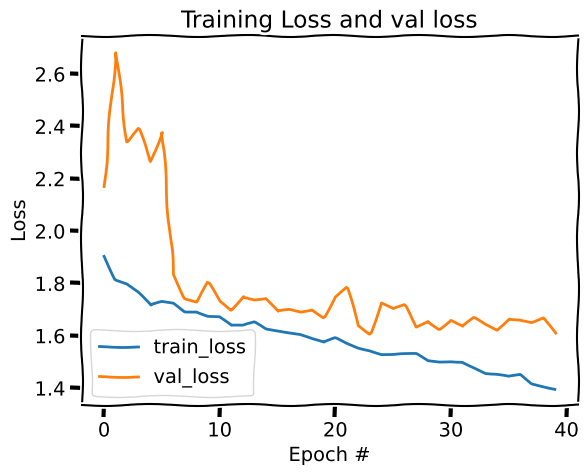

In [38]:
plot_loss(history)

### **Model Evaluation**

In [51]:
pred_y = np.argmax(bilstm_model.predict(test_X), axis=1)

25/25 [==============================] - 1s 45ms/step


In [ ]:
custom_metric_gen = Metrics(pred_y, test_y, list(label_map.keys()), "weighted", True)
print(custom_metric_gen.get_classification_report)

In [74]:
# accuracy.
custom_metric_gen.accuracy

0.39875

In [75]:
# classifcation matrix
print(custom_metric_gen.get_classification_report)

               precision    recall  f1-score   support

   Electronic       0.38      0.51      0.43       100
 Experimental       0.27      0.19      0.22       100
         Folk       0.36      0.39      0.37       100
      Hip-Hop       0.72      0.54      0.62       100
 Instrumental       0.36      0.62      0.46       100
International       0.44      0.21      0.28       100
          Pop       0.30      0.09      0.14       100
         Rock       0.40      0.64      0.49       100

     accuracy                           0.40       800
    macro avg       0.40      0.40      0.38       800
 weighted avg       0.40      0.40      0.38       800



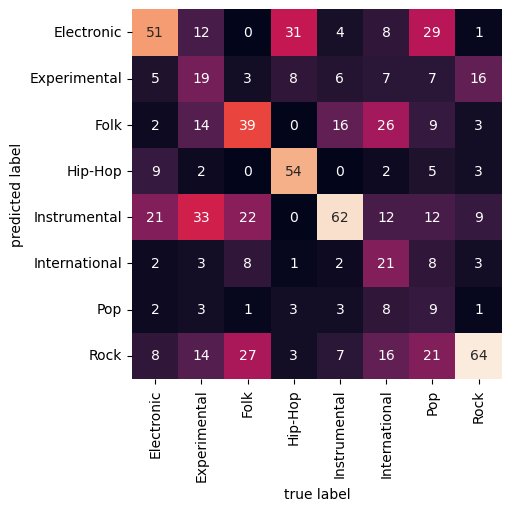

In [80]:
custom_metric_gen.heatmap_cmat